<a href="https://colab.research.google.com/github/cleitonmoya/CPS765_Trabalho2/blob/main/CPS765_Trab2_Proposta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPS765 - Redes Complexas - Proposta de Trabalho

Alunos: Cleiton Almeida, Girolamo Santoro

## Amostra - Rede da Covid-19 nos Municípios do RJ

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

Série temporal da Covid19 nos municípios do RJ:

In [2]:
url = 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/covid-rj.csv'
df = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True)
df.sort_index(inplace=True)
df

,city,confirmed,deaths
date,,,
2020-03-05,Barra Mansa,1,0
2020-03-06,Barra Mansa,1,0
2020-03-06,Rio de Janeiro,1,0
2020-03-08,Rio de Janeiro,2,0
2020-03-08,Barra Mansa,1,0
...,...,...,...
2020-10-29,Paraty,1029,34
2020-10-29,Sapucaia,667,30
2020-10-29,Bom Jardim,204,4


Casos acumulados:

In [4]:
df_casos_acum = df.pivot(columns='city', values='confirmed')
# remoação dos dados "indefinidos"
df_casos_acum = df_casos_acum.loc[:, df_casos_acum.columns != 'Importados/Indefinidos']

Casos diários:

In [6]:
df_casos = df_casos_acum.diff(periods=1)

Visualizando os dados "crus" sem a série da cidade do Rio (destoante):

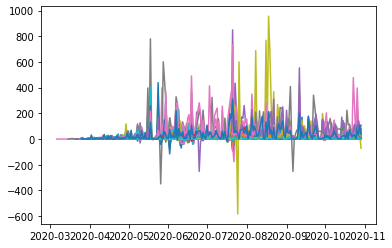

In [7]:
plt.plot(df_casos.loc[:, df_casos.columns != 'Rio de Janeiro'])
plt.show()

Observamos a presença de casos negativos, os quais deverão ser posteriormente tratados.

In [10]:
df_casos[df_casos<0].count()

city
Angra dos Reis         2
Aperibé                8
Araruama               5
Areal                  4
Armação dos Búzios    11
                      ..
Três Rios              5
Valença                8
Varre-Sai              0
Vassouras              5
Volta Redonda          5
Length: 92, dtype: int64

Aplicando média móvel de 7 dias:

In [11]:
df_casos_mm = df_casos.rolling(7).mean().dropna()

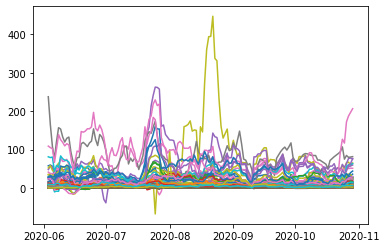

In [13]:
plt.plot(df_casos_mm.loc[:, df_casos_mm.columns != 'Rio de Janeiro'])
plt.show()

Matriz de correlação:

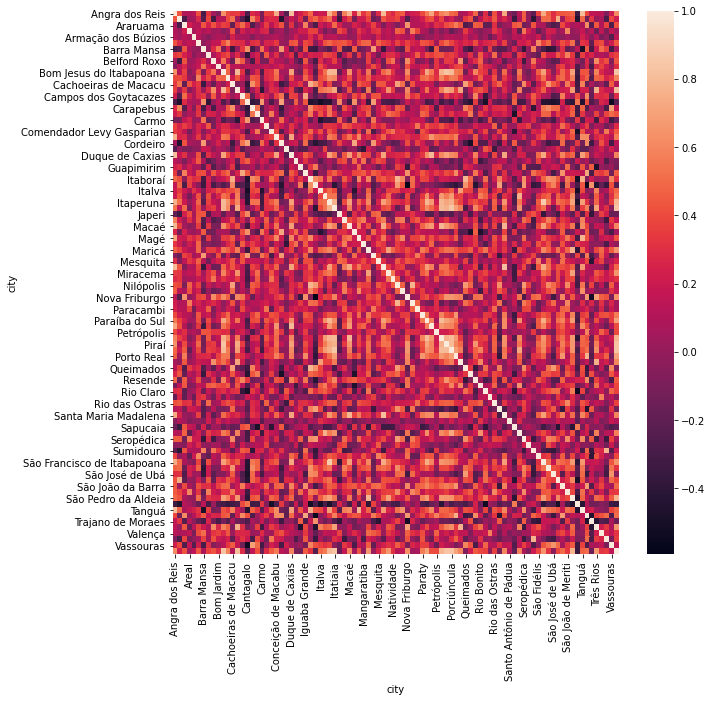

In [14]:
M_Cor = df_casos_mm.corr()
fig, axs = plt.subplots(figsize=(10,10))
ax = sns.heatmap(M_Cor)

Limiar para a definição das arestas da rede:

In [17]:
(df_casos_mm.corr() >= 0.6).sum()

city
Angra dos Reis        14
Aperibé                2
Araruama               3
Areal                  1
Armação dos Búzios     1
                      ..
Três Rios              8
Valença                1
Varre-Sai              2
Vassouras              4
Volta Redonda         19
Length: 92, dtype: int64

In [18]:
(df_casos_mm.corr() >= 0.6).sum().describe()

count    92.000000
mean      5.934783
std       5.350987
min       1.000000
25%       1.000000
50%       4.000000
75%       8.250000
max      20.000000
dtype: float64

Distribuição de grau:

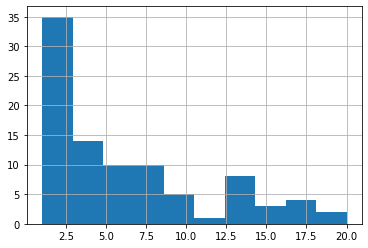

In [19]:
(df_casos_mm.corr() >= 0.6).sum().hist()
plt.show()

Observamos uma distribuição de grau aparentemente com cauda pesada.

In [20]:
A = (df_casos_mm.corr() >= 0.6).to_numpy().astype(int)

In [21]:
G = nx.from_numpy_matrix(A)

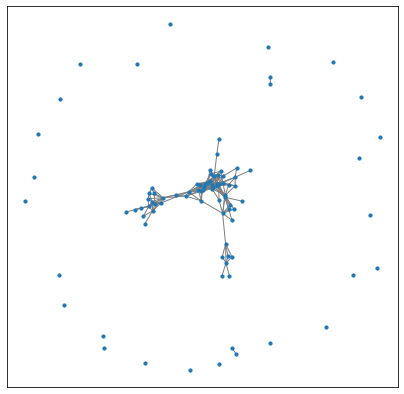

In [22]:
random.seed(42)
np.random.seed(42)
plt.figure(figsize=(7,7))
nx.draw_networkx(G, node_size=10, edge_color='grey', alpha=1, width=1, with_labels=False)
plt.show()

### Melhor ilustrando o significado das areastas:

In [23]:
M_Cor['Itatiaia']

city
Angra dos Reis        0.531105
Aperibé               0.181941
Araruama              0.497334
Areal                -0.084243
Armação dos Búzios    0.142434
                        ...   
Três Rios             0.703407
Valença               0.158149
Varre-Sai             0.296705
Vassouras            -0.042790
Volta Redonda         0.835405
Name: Itatiaia, Length: 92, dtype: float64

Itatiaia x Volta Redonda:

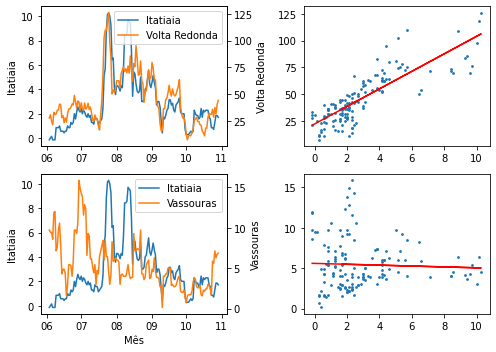

In [24]:
from scipy.stats import linregress
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')

fig, ax = plt.subplots(2, 2,figsize=(7,5))

x = df_casos_mm['Itatiaia']
y = df_casos_mm['Volta Redonda']
ax[0,0].plot(x, label='Itatiaia')
ax2 = ax[0,0].twinx()
ax2.plot(y, c='C1', label='Volta Redonda')
ax[0,0].set_ylabel('Itatiaia')
ax2.set_ylabel('Volta Redonda')

# Legendas
lines_1, labels_1 = ax[0,0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax[0,0].legend(lines, labels, loc=0)
ax[0,0].xaxis.set_major_locator(months)
ax[0,0].xaxis.set_major_formatter(months_fmt)

# Scatter
ax[0,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
ax[0,1].plot(x, m*x+b, c='r')

# Itatiaia x Vassouras
y = df_casos_mm['Vassouras']
ax[1,0].plot(x, label='Itatiaia')
ax2 = ax[1,0].twinx()
ax2.plot(y, c='C1', label='Vassouras')
ax[1,0].set_ylabel('Itatiaia')
ax2.set_ylabel('Vassouras')

# Legendas
lines_1, labels_1 = ax[1,0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax[1,0].legend(lines, labels, loc=0)
ax[1,0].xaxis.set_major_locator(months)
ax[1,0].xaxis.set_major_formatter(months_fmt)
ax[1,0].set_xlabel('Mês')

# Scatter
ax[1,1].scatter(x, y, s=3)
m, b, corr, _, _ = linregress(x, y)
ax[1,1].plot(x, m*x+b, c='r')

plt.tight_layout()
plt.show()